In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

# add the parent folder to path
lib_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(lib_path)

from bussineslogic.rto_data import RTODataModel


In [7]:
md = RTODataModel()
results_theta1 = pd.DataFrame(md.get_rto_results(8), columns=['index', 'var_name', 'value'])
results_theta05 = pd.DataFrame(md.get_rto_results(6), columns=['index', 'var_name', 'value'])
results_pv_theta1 = results_theta1.pivot(index='index', columns='var_name', values='value')
results_pv_theta05 = results_theta05.pivot(index='index', columns='var_name', values='value')

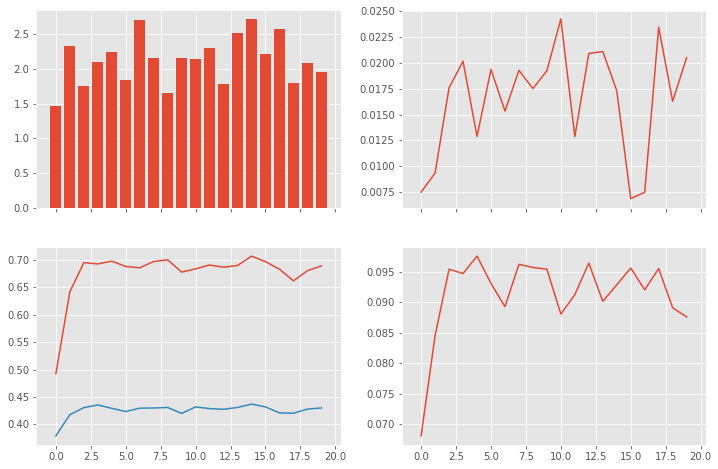

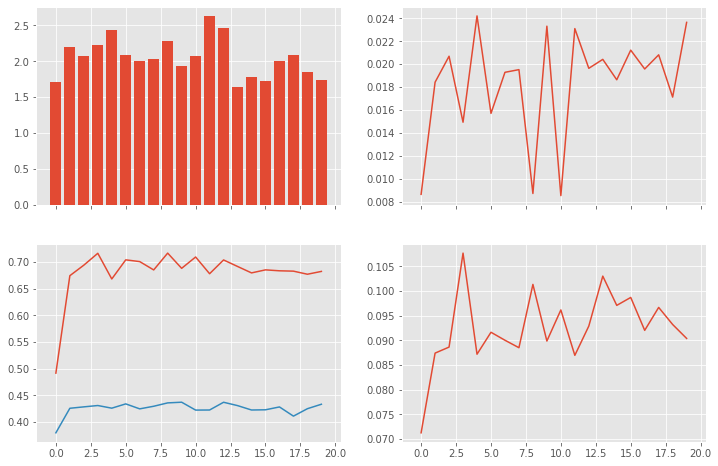

In [15]:
def plot_results(results_pv):
    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12,8))
    ax[0,1].plot(results_pv['Cb_tf'])
    ax[1,1].plot(results_pv['Cd_tf'])
    ax[1,0].plot(results_pv['cost_model'])
    ax[1,0].plot(results_pv['cost_real'])
    ax[0,0].bar(x=results_pv.index, height=results_pv['error'])

    fig.show()

plot_results(results_pv_theta05)
plot_results(results_pv_theta1)